In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.animation import FuncAnimation, PillowWriter
import cv2
import sys
import pickle
import time
from IPython.display import clear_output
import os
import re
import imageio
sys.path.append('..')
from helper_functions import *

big_plot_dim = 8

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()



using device: cuda


In [2]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import numpy as np

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda"

# iamge directory
image_folder = "/home/yashas/dev_ws/recordings/recording_2024-10-04_15-05-24"
image_dir = os.path.join(image_folder, "image.1728079528.927726.png")
# image_dir = "/home/yashas/dev_ws/recordings/recording_2024-10-04_15-05-24/image.1728079528.927726.png"


processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image = Image.open(image_dir)
# Check for cats and remote controls
text = "a robot gripper. a box. a soda can. a travel mug. a water bottle. a hammer. a bowl. a table."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.2,
    text_threshold=0.2,
    target_sizes=[image.size[::-1]]
)

print(results)
# print(results['labels'])
# print(results['scores'])
print("Boxes:")
print(results[0]['boxes'][2])

[{'scores': tensor([0.7225, 0.8679, 0.7813, 0.5655, 0.4840, 0.4964, 0.3217, 0.3259, 0.4111,
        0.2309, 0.2006, 0.2910, 0.2095], device='cuda:0'), 'labels': ['a hammer', 'a bowl', 'a travel mug', 'a box', 'a soda', 'a table', 'a robot gripper', 'a robot gripper', 'a water bottle', 'a water bottle', 'grip', 'a soda a water bottle', 'a'], 'boxes': tensor([[7.8138e+02, 2.5374e+02, 1.0344e+03, 4.4466e+02],
        [7.7707e+02, 9.0586e+01, 9.7615e+02, 2.5623e+02],
        [5.2862e+02, 7.8308e+01, 6.4907e+02, 2.6652e+02],
        [9.0942e+01, 2.1913e+00, 5.1388e+02, 4.0766e+02],
        [7.8786e+02, 1.0263e+00, 8.7226e+02, 1.1771e+02],
        [6.0729e+00, 1.9499e+01, 1.2752e+03, 7.1252e+02],
        [4.0678e+02, 2.0909e+02, 1.2738e+03, 6.7388e+02],
        [4.0546e+02, 2.1250e+02, 7.1574e+02, 6.3532e+02],
        [1.0184e+03, 1.7536e+00, 1.1970e+03, 1.9836e+02],
        [6.9239e-01, 1.4943e+01, 4.2487e+01, 1.0428e+02],
        [6.0923e+02, 3.5305e+02, 1.2764e+03, 6.2043e+02],
        [7

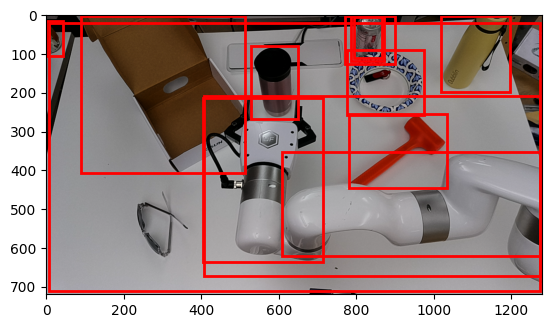

In [3]:
# visualize the bounding boxes overlaid on top of the image
import matplotlib.pyplot as plt

# Convert image to numpy array
image_np = np.array(image)

# Create a figure and axis
fig, ax = plt.subplots(1)

# Plot the image
ax.imshow(image_np)

# Plot the bounding boxes
for box in results[0]['boxes']:
    # Convert the box to the format (x1, y1, x2, y2)
    x1, y1, x2, y2 = box
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    # Draw the rectangle
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))

# Show the plot
plt.show()

In [4]:
from sam2.build_sam import build_sam2 # type: ignore
from sam2.sam2_image_predictor import SAM2ImagePredictor # type: ignore

sam2_checkpoint = "/home/yashas/Documents/thesis/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
predictor.set_image(image)

(8, 4)
['a hammer', 'a bowl', 'a travel mug', 'a box', 'a soda', 'a table', 'a robot gripper', 'a water bottle']
(8, 1, 720, 1280)


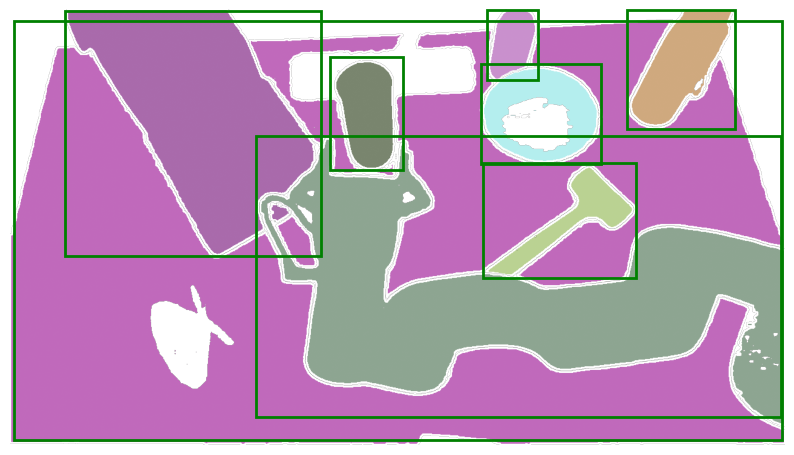

In [6]:
input_boxes = results[0]['boxes'].cpu().numpy()
# only keep selected boxes
input_boxes = input_boxes[[0, 1, 2, 3, 4, 5, 6, 8]]
input_boxes = input_boxes.astype(np.int64)
input_box = input_boxes[2]
print(input_boxes.shape)

labels = results[0]['labels']
# only keep selected labels
labels = [labels[i] for i in [0, 1, 2, 3, 4, 5, 6, 8]]
print(labels)

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False, 
)

print(masks.shape)

# visualize the masks overlaid on top of the image
plt.figure(figsize=(10, 10))
# plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

(8, 1, 720, 1280)
(8,)
(8, 4)


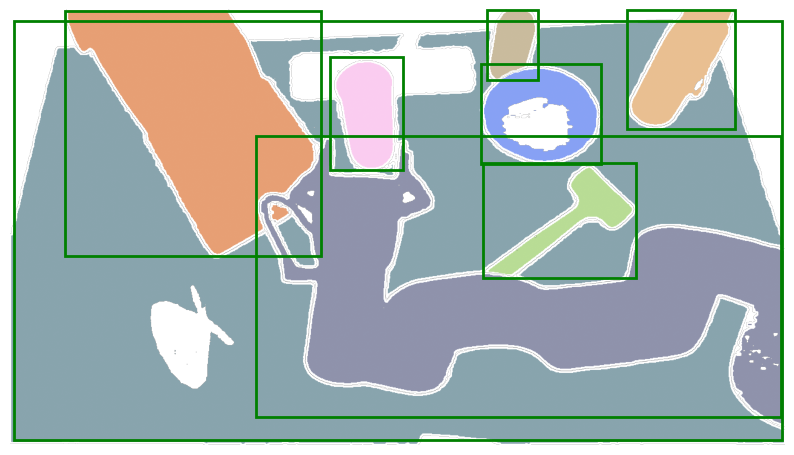

In [7]:
# save the masks along with their labels to a file
import json

# Create a dictionary to store the masks and their labels
masks_dict = {
    "image_name": image_dir,
    "masks": masks.tolist(),
    "labels": labels,
    "boxes": input_boxes.tolist()
}

# Save the dictionary to a JSON file
json_file_path = os.path.join(image_folder, "masks_and_labels.json")
with open(json_file_path, 'w') as f:
    json.dump(masks_dict, f)

# load the masks and labels from the json file
with open('masks_and_labels.json', 'r') as f:
    masks_dict = json.load(f)

imported_masks = np.array(masks_dict['masks'])
imported_labels = np.array(masks_dict['labels'])
imported_boxes = np.array(masks_dict['boxes'])

print(imported_masks.shape)
print(imported_labels.shape)
print(imported_boxes.shape)

# visualize the masks overlaid on top of the image
plt.figure(figsize=(10, 10))
# plt.imshow(image)
for mask in imported_masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in imported_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [110]:
# Raycast out from the centroid and find the distance to the outer border of the mask
# TODO: Implement logic for when centroid point is outside the mask- need to employ special logic in that case
def raycast(mask, point, angle, max_dist):
    furthest_dist = -1
    in_bounds = True
    for i in range(max_dist):
        x = int(point[0] + i * np.cos(angle))
        y = int(point[1] + i * np.sin(angle))
        if x < 0 or y < 0 or x >= mask.shape[1] or y >= mask.shape[0]:
            if in_bounds:
                furthest_dist = i
            return furthest_dist
        if not in_bounds and mask[y, x] == 1:
            in_bounds = True
            # furthest_dist = i
        if in_bounds and mask[y, x] == 0:
            in_bounds = False
            furthest_dist = i
    return furthest_dist

# function that finds closest nonzero depth value in a radius around a point, closest to the point
def find_closest_depth(depth_array, point, radius):
    y, x = int(point[1]), int(point[0])
    height, width = depth_array.shape
    
    for r in range(1, radius + 1):
        for dy in range(-r, r + 1):
            for dx in range(-r, r + 1):
                # Check if we're on the edge of the current radius
                if abs(dy) == r or abs(dx) == r:
                    ny, nx = y + dy, x + dx
                    
                    # Check if the point is within the image bounds
                    if 0 <= ny < height and 0 <= nx < width:
                        depth = depth_array[ny, nx]
                        
                        # If we find a non-zero depth, return it
                        if depth != 0:
                            return depth
    
    # If no non-zero depth is found within the radius, return 0
    return 0

# function to get the depth value at the end of each raycast for one mask
def get_depth_raycast_values(mask, centroid, depth_array, num_rays, radius):
    depths = []
    for k in range(num_rays):
        angle = k * 2 * np.pi / num_rays
        raycast_distance = raycast(mask, centroid, angle, 1500)
        depths.append(find_closest_depth(depth_array, [centroid[0] + raycast_distance * np.cos(angle), centroid[1] + raycast_distance * np.sin(angle)], radius))
    return depths

def tokenize_single_mask(mask, id, num_rays, depth_array):
    # Find the centroid of the mask
    centroid = find_centroid(mask)
    # Tokenize the mask
    tokens = []
    tokens.append(str(id))
    tokens.append(centroid[0])
    tokens.append(centroid[1])
    str_tok = "{"
    str_tok += str(id)
    str_tok += (",{")
    str_tok += str(centroid[0])
    str_tok += (",")
    str_tok += str(centroid[1])
    str_tok += ("},{")
    for i in range(num_rays):
        angle = i * 2 * np.pi / num_rays
        raycast_distance = raycast(mask, centroid, angle, 1500)
        tokens.append(raycast_distance)
        str_tok += (",")
        str_tok += str(raycast_distance)
    str_tok += ("},{")
    depths = get_depth_raycast_values(mask, centroid, depth_array, num_rays, 100)
    for depth in depths:
        tokens.append(depth)
        str_tok += (",")
        str_tok += str(depth)
    str_tok += ("}}")
    return tokens, str_tok

def tokenize_masks(masks, labels, num_rays, depth_array):
    ret_tokens = []
    str_tokens = []
    # for i in range(len(masks)):
    #     if i == 0:
    #         arr, str = tokenize_single_mask(masks[i], "gripper", num_rays)
    #     elif i == 1:
    #         arr, str = tokenize_single_mask(masks[i], "table", num_rays)
    #     elif i == 2:
    #         arr, str = tokenize_single_mask(masks[i], "yellow block", num_rays)
    #     elif i == 3:
    #         arr, str = tokenize_single_mask(masks[i], "green block", num_rays)
    #     elif i == 4:
    #         arr, str = tokenize_single_mask(masks[i], "blue block", num_rays)
    #     elif i == 5:
    #         arr, str = tokenize_single_mask(masks[i], "red block", num_rays)
    #     else:
    #         arr, str = tokenize_single_mask(masks[i], i, num_rays)
    #     ret_tokens.append(arr)
    #     str_tokens.append(str)
    #     # print('Tokens for mask', i, ':', tokens)
    for i in range(len(masks)):
        tokens, str_tok = tokenize_single_mask(masks[i][0], labels[i], num_rays, depth_array)
        ret_tokens.append(tokens)
        str_tokens.append(str_tok)
    return ret_tokens, str_tokens

# Given a list of points that represent a polygon, write a function to convert it to a mask
def polygon_to_mask(polygon, width, height):
    mask = np.zeros((height, width))
    polygon = np.array(polygon, np.int32)
    mask = cv2.fillPoly(mask, [polygon], 1)
    return mask

# Given a centroid and a list of radiused points and the height and width of the original image, reconstruct the mask, making sure all the points inside the polygon are filled in
def reconstruct_mask(centroid, radiused_points, width, height):
    mask = np.zeros((height, width))
    polygon_points = []
    for i in range(len(radiused_points)):
        angle = i * 2 * np.pi / len(radiused_points)
        polygon_points.append([int(centroid[0] + radiused_points[i] * np.cos(angle)), int(centroid[1] + radiused_points[i] * np.sin(angle))])

    mask = polygon_to_mask(polygon_points, width, height)
    return mask

(8, 2)


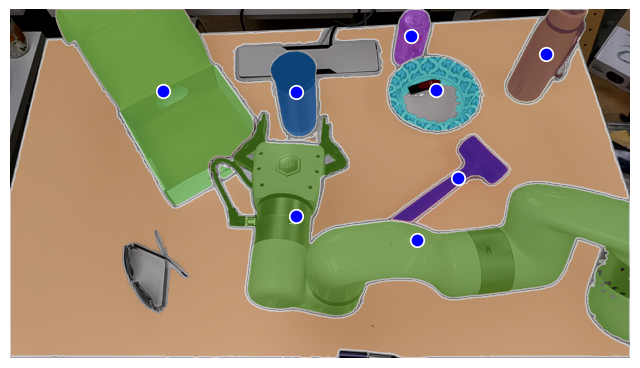

['gripper', 925, 347, 93, 18, 15, 15, 15, 16, 18, 23, 34, 72, 154, 53, 26, 18, 14, 12, 12, 12, 13, 68, 91, 88, 87, 91, 103, 1002, 1009, 1009, 1009, 1009, 1006, 1002, 976, 980, 978, 682, 1013, 1009, 1011, 1015, 1015, 1024, 1030, 1028, 1017, 1050, 1062, 1086, 1028, 1009]
{gripper,{925,347},{,93,18,15,15,15,16,18,23,34,72,154,53,26,18,14,12,12,12,13,68,91,88,87,91,103},{,1002,1009,1009,1009,1009,1006,1002,976,980,978,682,1013,1009,1011,1015,1015,1024,1030,1028,1017,1050,1062,1086,1028,1009}}
[['a hammer', 925, 347, 93, 18, 15, 15, 15, 16, 18, 23, 34, 72, 154, 53, 26, 18, 14, 12, 12, 12, 13, 68, 91, 88, 87, 91, 103, 1002, 1009, 1009, 1009, 1009, 1006, 1002, 976, 980, 978, 682, 1013, 1009, 1011, 1015, 1015, 1024, 1030, 1028, 1017, 1050, 1062, 1086, 1028, 1009], ['a bowl', 878, 166, 93, 95, 97, 95, 92, 89, 88, 87, 87, 90, 93, 98, 97, 95, 91, 85, 79, 73, 71, 70, 69, 72, 76, 81, 85, 1081, 1067, 1048, 1028, 1017, 1015, 1009, 1019, 1017, 1024, 1035, 1050, 1074, 1088, 1132, 1106, 1096, 1088, 1091

In [112]:
centroids = []
for i in range(len(imported_masks)):
    mask = imported_masks[i][0]
    centroid = find_centroid(mask)
    # print(centroid)
    centroids.append(centroid)

centroids = np.array(centroids)
print(centroids.shape)

depth_image_dir = os.path.join(image_folder, "depth.1728079528.927726.png")
depth_image = Image.open(depth_image_dir)
depth_image = np.array(depth_image)
depth_array = np.array(depth_image)
depth_image = depth_image * 50
depth_image = Image.fromarray(depth_image)

# visualize the centroids
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(image)
for mask in imported_masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
# for box in imported_boxes:
#     show_box(box, plt.gca())
for i in range(len(centroids)):
    plt.scatter(centroids[i][0], centroids[i][1], color='blue', marker='.', s=375, edgecolor='white', linewidth=1.25)
plt.axis('off')
plt.show()

angle = np.pi
max_dist = 400
raycast_distances = []
num_rays = 25
tokens, str_tok = tokenize_single_mask(imported_masks[0][0], "gripper", num_rays, depth_array)
print(tokens)
print(str_tok)

frame_tokens, string_tokens = tokenize_masks(imported_masks, imported_labels, num_rays, depth_array)
print(frame_tokens)
print(string_tokens)

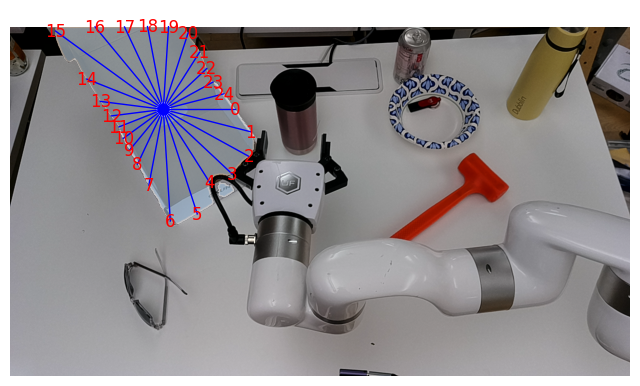

In [79]:
# Visualize frame_tokens
plt.figure(figsize=(big_plot_dim, big_plot_dim))
# plt.title('Frame ' + str(0))
plt.imshow(image)
show_mask_num = 3
for j in range(imported_masks.shape[0]):
    if j == show_mask_num:
        show_mask(imported_masks[j][0], plt.gca(), random_color=True)
for j in range(imported_masks.shape[0]):
    if j == show_mask_num:
        plt.scatter(centroids[j][0], centroids[j][1], color='blue', marker='.', s=375, edgecolor='white', linewidth=1.25)
        for k in range(num_rays):
            # show the value of k on the plot next to the end of the raycast
            plt.text(centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays), centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays), str(k), color='red', fontsize=12, ha='center', va='center')
            plt.plot([centroids[j][0], centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays)], [centroids[j][1], centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays)], color='blue', linestyle='-',linewidth=1)
plt.axis('off')
plt.show()

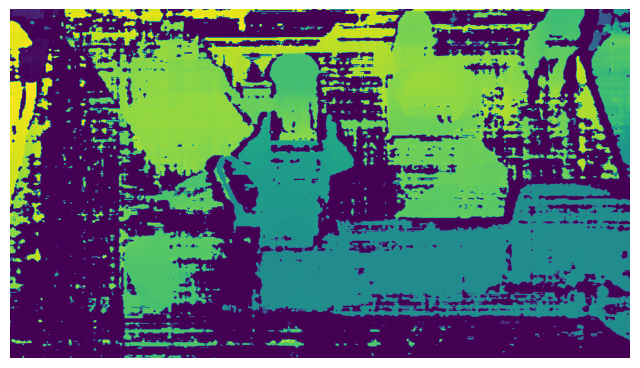

[1009, 1108, 918, 1091, 1046, 688, 633, 988]
[[1002, 1009, 1009, 1009, 1009, 1006, 1002, 976, 980, 978, 682, 1013, 1009, 1011, 1015, 1015, 1024, 1030, 1028, 1017, 1050, 1062, 1086, 1028, 1009], [1081, 1067, 1048, 1028, 1017, 1015, 1009, 1019, 1017, 1024, 1035, 1050, 1074, 1088, 1132, 1106, 1096, 1088, 1091, 1098, 1096, 1093, 1088, 1083, 1071], [964, 982, 994, 1013, 1048, 1069, 1074, 1064, 1037, 998, 994, 978, 980, 1015, 916, 932, 930, 1170, 1162, 1173, 1159, 922, 920, 918, 962], [1026, 1011, 1086, 695, 1069, 1002, 964, 958, 1124, 1170, 1044, 1015, 1000, 1151, 1026, 1386, 1194, 1243, 1250, 1253, 1269, 1227, 1188, 1064, 1048], [1050, 1057, 1048, 1083, 1088, 1096, 1098, 1093, 1108, 1148, 1103, 1182, 1114, 1203, 1114, 1057, 1062, 1060, 1215, 1224, 1234, 1212, 1055, 1041, 1046], [984, 648, 667, 964, 958, 958, 1019, 964, 955, 930, 1145, 1083, 1064, 1212, 1279, 1367, 687, 1191, 2480, 2493, 1230, 1145, 2467, 1194, 1098], [633, 643, 699, 655, 633, 633, 633, 633, 633, 633, 677, 643, 673, 690, 10

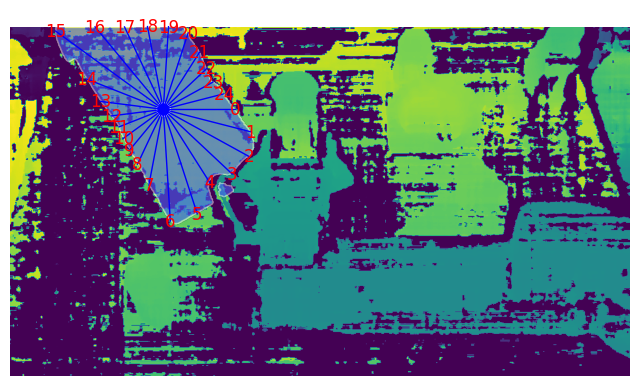

In [106]:
# import and display the depth image
depth_image_dir = os.path.join(image_folder, "depth.1728079528.927726.png")
depth_image = Image.open(depth_image_dir)
depth_image = np.array(depth_image)
depth_array = np.array(depth_image)
depth_image = depth_image * 50
depth_image = Image.fromarray(depth_image)
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(depth_image)
plt.axis('off')
plt.show()

# get the depth value at the centroid of each mask
depth_values = []
for i in range(len(imported_masks)):
    mask = imported_masks[i][0]
    centroid = centroids[i]
    depth_values.append(depth_array[int(centroid[1]), int(centroid[0])])

print(depth_values)

# get the depth value at the end of each raycast of each mask
# depth_raycast_values = []
# for i in range(len(imported_masks)):
#     mask = imported_masks[i][0]
#     centroid = centroids[i]
#     for k in range(num_rays):
#         angle = k * 2 * np.pi / num_rays
#         raycast_distance = raycast(mask, centroid, angle, 1500)
#         depth_raycast_values.append(depth_array[int(centroid[0] + raycast_distance * np.cos(angle)), int(centroid[1] + raycast_distance * np.sin(angle))])

# print(depth_raycast_values)


# get depth value at the end of each raycast
depth_raycast_values = []
for i in range(imported_masks.shape[0]):
    mask = imported_masks[i][0]
    centroid = centroids[i]
    depths = []
    for k in range(num_rays):
        angle = k * 2 * np.pi / num_rays
        raycast_distance = raycast(mask, centroid, angle, 1500)
        depths.append(find_closest_depth(depth_array, [centroid[0] + raycast_distance * np.cos(angle), centroid[1] + raycast_distance * np.sin(angle)], 100))
    depth_raycast_values.append(depths)

print(depth_raycast_values)

# Visualize frame_tokens
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(depth_image)
show_mask_num = 3
# print("centroid:")
# print(centroids[show_mask_num])
print("frame_tokens:")
print(frame_tokens)
for j in range(imported_masks.shape[0]):
    if j == show_mask_num:
        show_mask(imported_masks[j][0], plt.gca(), random_color=True)
for j in range(imported_masks.shape[0]):
    if j == show_mask_num:
        plt.scatter(centroids[j][0], centroids[j][1], color='blue', marker='.', s=375, edgecolor='white', linewidth=1.25)
        for k in range(num_rays):
            # show the value of k on the plot next to the end of the raycast
            # print(centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays))
            # print(centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays))
            # print(depth_array[int(centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays)), int(centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays))])
            # print(find_closest_depth(depth_array, [centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays), centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays)], 10))
            plt.text(centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays), centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays), str(k), color='red', fontsize=12, ha='center', va='center')
            plt.plot([centroids[j][0], centroids[j][0] + frame_tokens[j][k+3] * np.cos(k * 2 * np.pi / num_rays)], [centroids[j][1], centroids[j][1] + frame_tokens[j][k+3] * np.sin(k * 2 * np.pi / num_rays)], color='blue', linestyle='-',linewidth=1)
plt.axis('off')
plt.show()